In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
df = pd.read_csv("encoded_df.csv")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for ervaring_0 in df['ervaring_0'].unique():
    for geslacht_M in df['geslacht_M'].unique():
        for gewichtsklasse_L in df['gewichtsklasse_L'].unique():
            subset = df[(df['ervaring_0'] == ervaring_0) & 
                        (df['geslacht_M'] == geslacht_M) & 
                        (df['gewichtsklasse_L'] == gewichtsklasse_L)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])


train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print(f"Trainingsdata: {len(train_data)} rijen")
print(f"Validatiedata: {len(val_data)} rijen")
print(f"Testdata: {len(test_data)} rijen")

Trainingsdata: 3018 rijen
Validatiedata: 905 rijen
Testdata: 391 rijen


In [7]:
X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']

X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']

X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

#maakt geen verschil
# scaler = StandardScaler()
# scaler.fit(X_train) 
# X_train_scaled = scaler.transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

mse_test = 55.53114896088057
mse_val = 64.38761185355155
rse_test = 7.451922500998019
train_r2 = 0.9470372200012207
val_r2 = 0.9371916651725769
test_r2 = 0.9459664821624756
   Actual 2k tijd  Predicted 2k tijd (XGBoost)  Difference (XGBoost)
0             427                   419.660492              7.339508
1             420                   427.399536             -7.399536
2             418                   422.979370             -4.979370
3             427                   425.417694              1.582306
4             427                   428.181580             -1.181580
5             420                   421.598419             -1.598419
6             421                   421.231445             -0.231445
7             449                   426.441010             22.558990
8             431                   427.472748              3.527252
9             431                   425.100555              5.899445


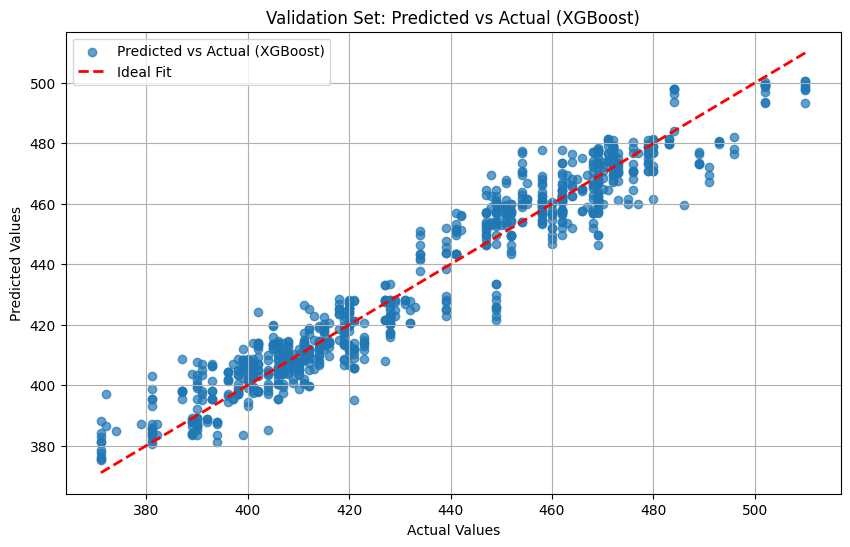

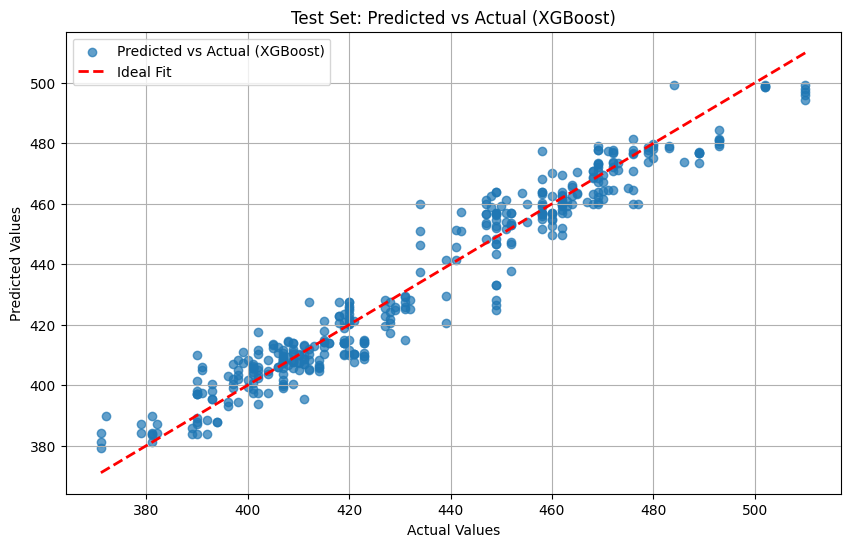

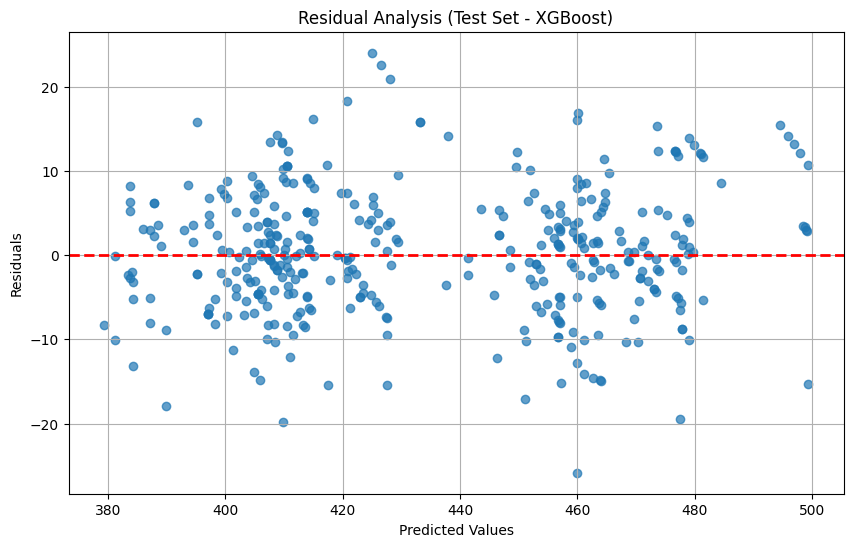

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

continuous_features = ['500_split']
binary_features = [col for col in X_train.columns if col not in continuous_features]

scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[continuous_features])
X_val_cont = scaler.transform(X_val[continuous_features])
X_test_cont = scaler.transform(X_test[continuous_features])

X_train_bin = X_train[binary_features].replace({0: -1, 1: 1}).values
X_val_bin = X_val[binary_features].replace({0: -1, 1: 1}).values
X_test_bin = X_test[binary_features].replace({0: -1, 1: 1}).values

X_train_processed = np.hstack((X_train_cont, X_train_bin))
X_val_processed = np.hstack((X_val_cont, X_val_bin))
X_test_processed = np.hstack((X_test_cont, X_test_bin))

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, reg_lambda=150)

xgb_model.fit(X_train_processed, y_train)

train_pred = xgb_model.predict(X_train_processed)
test_pred = xgb_model.predict(X_test_processed)
val_pred = xgb_model.predict(X_val_processed)

mse_test = mean_squared_error(y_test, test_pred)
mse_val = mean_squared_error(y_val, val_pred)
print(f"mse_test = {mse_test}")
print(f"mse_val = {mse_val}")

rse_test = np.sqrt(mse_test)
print(f"rse_test = {rse_test}")

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"train_r2 = {train_r2}")
print(f"val_r2 = {val_r2}")
print(f"test_r2 = {test_r2}")

results_xgb = pd.DataFrame({
    'Actual 2k tijd': y_test,
    'Predicted 2k tijd (XGBoost)': test_pred,
    'Difference (XGBoost)': y_test - test_pred
})
print(results_xgb.head(10))

plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_pred, alpha=0.7, label='Predicted vs Actual (XGBoost)')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Validation Set: Predicted vs Actual (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.7, label='Predicted vs Actual (XGBoost)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Predicted vs Actual (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

residuals_xgb = y_test - test_pred
plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals_xgb, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Test Set - XGBoost)')
plt.grid(True)
plt.show()

In [10]:
param_grid = {'reg_lambda': [0.1, 1, 10, 100, 150, 500]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_lambda = grid_search.best_params_['reg_lambda']
print("Best lambda (reg_lambda):", best_lambda)


Best lambda (reg_lambda): 150
